In [52]:
import os
import numpy as np
import re

In [53]:
class scan:
     def __init__(self):
        self.ID = "" 
        self.annealed = False
        self.reflection = "004"
        self.omega = []
        self.intensity = []
        self.fitted = fitted()

class fitted:
    def __init__(self):
        self.A = 0
        self.B = 0
        self.rho = 0
        self.f = 0

Here I just import all files as a list of structs (or classes, whatever)

In [54]:
projections_path = "Data/Projection_SiGePeak/"

regex = r"\d{5}"

scans = []

for fileID in os.listdir(projections_path):
    file = os.fsdecode(fileID)
    file = projections_path + file
    temp = scan()

    temp.ID = (re.findall(r'(?<!\d)(\d{5})(?!\d)', file))[0]

    if temp.ID == None:
        print("Sample ID is not known!")
        exit(1)

    if "annealed" in file:
        temp.annealed = True
    elif "as_grown":
        temp.annealed = False
    else:
        print("Error, not a known annealing state!")
        exit(1)

    if "004" in file:
        temp.reflection = "004"
    elif "224" in file:
         temp.reflection = "224"
    else:
        print("Error, not a known reflection!")
        exit(1)
    
    temp.omega, _, _, _, _, _, _, _, _, temp.intensity = np.genfromtxt(file, dtype=float, skip_header=7, unpack=True)

    scans.append(temp)

In [55]:
def shift_peak(scan):
    peak_Si = 34.6
    peak_el = scan.intensity.argmax()
    traslation = peak_Si - scan.omega[peak_el]
    scan.omega = scan.omega + traslation
    return scan

def normalize_intensity(scan):
    intensity_max = scan.intensity.max()
    scan.intensity = scan.intensity/intensity_max
    return scan
    

Text(0.5, 1.0, '004, Aligned Peaks, Normalized Intensities')

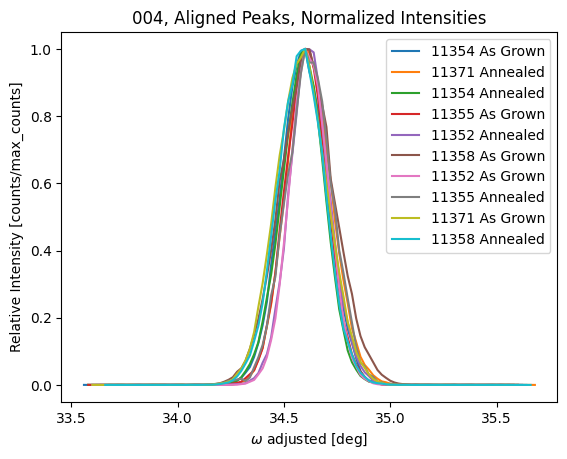

In [56]:
import matplotlib.pyplot as plt
from copy import deepcopy

for scan in scans:
    if scan.reflection == "004":
        t = deepcopy(scan) # SUPER ugly but works
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.plot(t.omega, (t.intensity), label = t.ID + " " + ("Annealed" if t.annealed else "As Grown"))
plt.legend()
plt.xlabel(r"$\omega$ adjusted [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("004, Aligned Peaks, Normalized Intensities")


Text(0.5, 1.0, '224, Aligned Peaks, Normalized Intensities')

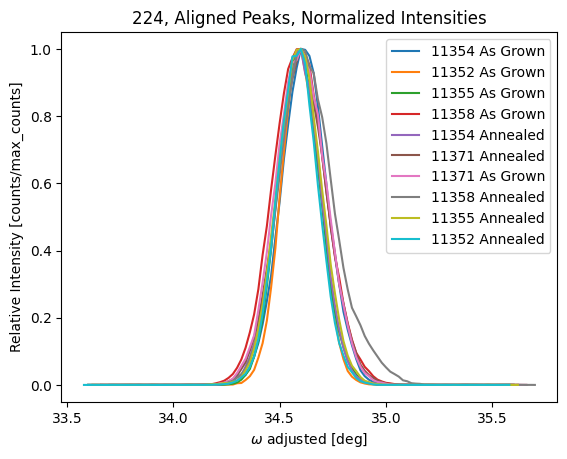

In [57]:

for scan in scans:
    if scan.reflection == "224":
        t = deepcopy(scan) # SUPER ugly but works
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.plot(t.omega, (t.intensity), label = t.ID + " " + ("Annealed" if t.annealed else "As Grown"))
plt.legend()
plt.xlabel(r"$\omega$ adjusted [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("224, Aligned Peaks, Normalized Intensities")

Text(0.5, 1.0, 'Raw')

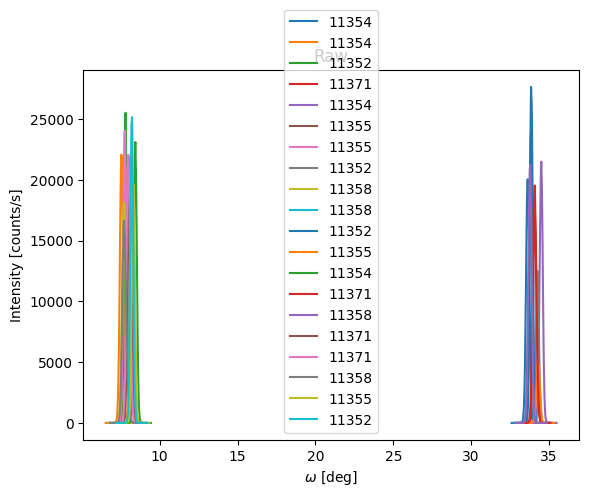

In [62]:
import matplotlib.pyplot as plt

for scan in scans:
    plt.plot(scan.omega, scan.intensity, label = scan.ID)
plt.legend()
plt.xlabel(r"$\omega$ [deg]")
plt.ylabel("Intensity [counts/s]")
plt.title("Raw")

In [59]:
def fit(scan): # Worng, just to test
    from scipy.optimize import curve_fit
    def lorentzian(x, A, B, rho, f):
        return A + B * (1/(1 + (4 * (x - rho)/f)**2))
    popt, pcov = curve_fit(lorentzian, scan.omega, scan.intensity)
    scan.fitted.A = popt[0]
    scan.fitted.B = popt[1]
    scan.fitted.rho = popt[2]
    scan.fitted.f = popt[3]
    return scan

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

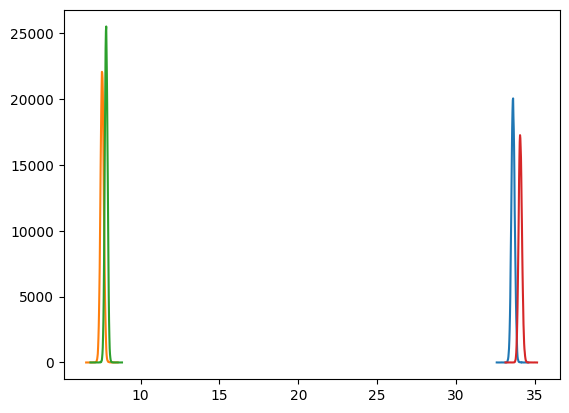

In [60]:
for scan in scans:
    fit(scan)
    plt.plot(scan.omega, scan.intensity, label = scan.ID)
    # Plot also fitted shape
plt.legend()
plt.xlabel(r"$\omega$ [deg]")
plt.ylabel("Intensity [counts/s]")
plt.title("Fitted")
    